* Import librairies

In [2]:
import os
import torch
from torch import nn # Neural Networks
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms # Apply transformation on image (Data augmentation)
from torchsummary import summary

* Download Multi-class Weather Dataset from kaggle

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d pratik2901/multiclass-weather-dataset
!unzip 'multiclass-weather-dataset.zip'
!kaggle datasets download -d pratik2901/multiclass-weather-dataset
%cd "/content/Multi-class Weather Dataset"

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 80% 73.0M/91.4M [00:00<00:00, 135MB/s]
100% 91.4M/91.4M [00:00<00:00, 132MB/s]
Archive:  multiclass-weather-dataset.zip
  inflating: Multi-class Weather Dataset/Cloudy/cloudy1.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy10.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy100.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy101.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy102.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy103.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy104.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy105.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy106.jpg  
  inflating: Multi-class Weather Dat

* Load all images from dataset


In [4]:
# Define transformations to be apply on the images
IMAGE_SIZE = 128
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize image to (128, 128)
    transforms.ToTensor(), # Normalize pixels to [0..1]
    ]
)


dataset = torchvision.datasets.ImageFolder(
        root="/content/Multi-class Weather Dataset", # data_path is path to directory
        transform=transform
)

print(dataset)

Dataset ImageFolder
    Number of datapoints: 1125
    Root location: /content/Multi-class Weather Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


* Divide dataset into train (70%) and test (30%) subsets

In [6]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(len(train_dataset), "train samples and", len(test_dataset), "test samples")

787 train samples and 338 test samples


* Create DataLoader object for train and test subsets

In [7]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 32,
                                           shuffle = True
)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = 32,
                                          shuffle = False
)

for batch_num, (images, targets) in enumerate(train_loader):
  print("Batch image size", images.shape, "---- Batch label size", targets.shape)

Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Ba

* Plot images from train_loader

Feature batch shape: torch.Size([32, 3, 128, 128])
Labels batch shape: torch.Size([32])


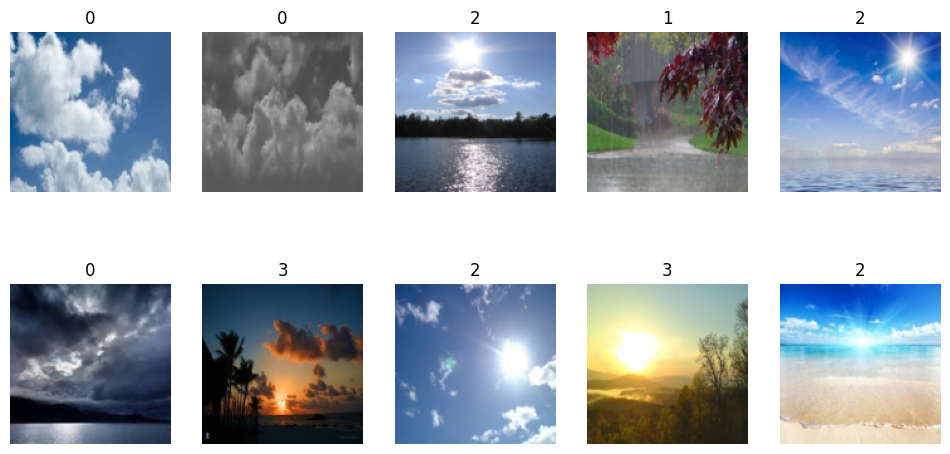

In [8]:
import matplotlib.pyplot as plt

train_loader1 = train_loader
train_features, train_labels = next(iter(train_loader1))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
indx = 0
f, axarr = plt.subplots(2, 5, figsize=(12, 6))

for r in range(0, 2):
  for c in range(0, 5):
    img = train_features[indx].squeeze()
    label = train_labels[indx]
    axarr[r, c].imshow(transforms.ToPILImage()(img))
    axarr[r, c].set_title(str(label.item()))
    axarr[r, c].set_axis_off()
    indx+=1

* Implement CNN model:
  - Block 1 :
    * Conv2D : 32 filters, kernel_size (3, 3), stride = (1, 1)
    * Activation layer : ReLU
    * MaxPooling2D : kernel_size = (2, 2), stride = (2, 2)
  - Block 2 :
    * Conv2D : 64 filters, kernel_size = (3, 3), stride = (1, 1)
    * Activation layer : ReLU
    * MaxPooling2D : kernel_size = (2, 2), stride = (2, 2)
  - Flatten
  - Linear : 128 neurons
  - Activation : ReLU
  - Linear : 4 neurons
  - Activation layer : Softmax

In [13]:
class CNN (nn.Module):

  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=(1,1)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Flatten(),
    nn.Linear(in_features=64*30*30, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=4),
    nn.Softmax(dim=1),
    )

  def forward (self, x):
    out = self.layers(x)
    return out

* Create an instance of CNN and turn it to CUDA device if available

In [14]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

# declare an instance of CNN
cnn = CNN()

# turn cnn to cuda device
cnn.to(device)

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=57600, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=4, bias=True)
    (10): Softmax(dim=1)
  )
)

* Show cnn summary

In [15]:
summary(cnn, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 126, 126]             896
              ReLU-2         [-1, 32, 126, 126]               0
         MaxPool2d-3           [-1, 32, 63, 63]               0
            Conv2d-4           [-1, 64, 61, 61]          18,496
              ReLU-5           [-1, 64, 61, 61]               0
         MaxPool2d-6           [-1, 64, 30, 30]               0
           Flatten-7                [-1, 57600]               0
            Linear-8                  [-1, 128]       7,372,928
              ReLU-9                  [-1, 128]               0
           Linear-10                    [-1, 4]             516
          Softmax-11                    [-1, 4]               0
Total params: 7,392,836
Trainable params: 7,392,836
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forw

* Define Loss function and optimizer

In [17]:
# Loss function
loss_function = nn.CrossEntropyLoss()

# optimizer Adam
optimizer = torch.optim.Adam(params = cnn.parameters(), lr=1e-4)

* Run the training Loop

In [18]:
epochs = 20

# set the model to the train mode
cnn.train()


for epoch in range(epochs):

  # define a list to store the losses of the different batches
  losses = []

  # iter over patches
  for batch_num, (train_images, train_targets) in enumerate(train_loader, 0):

    # initialize the optimizer (Zero the gradients)
    optimizer.zero_grad()


    # turn train_images and train_targets on cuda device
    train_images = train_images.to(device)
    train_targets = train_targets.to(device)

    # Propagate the images and return the predicted output (Perform forward pass)
    output = cnn(train_images)


    # calculate the loss between actual and predicted outputs (Compute loss)
    loss = loss_function(output, train_targets)
    losses.append(loss.item())

    # Prpagate the gradient of the loss in reverse (Perform backward pass)
    loss.backward()

    # update the model parameters (Perform optimization)
    optimizer.step()


  # print the average loss of the current epoch
  print('Epoch %d -- Loss %.4f' % (epoch, sum(losses)/len(losses)))

# Process is complete.
print('Training process has finished.')

Epoch 0 -- Loss 1.2379
Epoch 1 -- Loss 1.0326
Epoch 2 -- Loss 0.9551
Epoch 3 -- Loss 0.9309
Epoch 4 -- Loss 0.9236
Epoch 5 -- Loss 0.9167
Epoch 6 -- Loss 0.8944
Epoch 7 -- Loss 0.8881
Epoch 8 -- Loss 0.8745
Epoch 9 -- Loss 0.8743
Epoch 10 -- Loss 0.8756
Epoch 11 -- Loss 0.8634
Epoch 12 -- Loss 0.8643
Epoch 13 -- Loss 0.8588
Epoch 14 -- Loss 0.8428
Epoch 15 -- Loss 0.8395
Epoch 16 -- Loss 0.8391
Epoch 17 -- Loss 0.8343
Epoch 18 -- Loss 0.8273
Epoch 19 -- Loss 0.8249
Training process has finished.


* Save the trained model

In [19]:
torch.save(cnn, 'cnn_model.pth')

* Load the model and run evaluation

In [20]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

# load model saved in "mlp_model.pth"
cnn_model = torch.load('cnn_model.pth')

# turn cnn_model to cuda device if available
cnn_model = cnn_model.to(device)

total_samples = len(test_loader.dataset)
correct_samples = 0
total_loss = 0

# set the model in evaluation mode
cnn_model.eval()

# iter over batches
for num_batch, (test_images, test_targets) in enumerate(test_loader):

  # turn test_images and test_targets on cuda device
  test_images = test_images.to(device)
  test_targets = test_targets.to(device)

  # calculate logits
  outputs = cnn_model(test_images)

  # calculate loss
  loss = loss_function(outputs, test_targets)
  total_loss += loss.item()

  # predict classes from outputs
  pred_targets = outputs.argmax(dim=1)

  # calculate correct predictions
  nb_correct = pred_targets.eq(test_targets).sum()
  correct_samples += nb_correct

avg_loss = total_loss / len(test_loader)
val_accuracy = (correct_samples / total_samples)

print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  val_accuracy:' + '{:.4f}'.format(val_accuracy) + '\n')

<ipython-input-20-8d7342456245>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model = torch.load('cnn_model.pth')



Average test loss: 0.8730  val_accuracy:0.8757

